<a href="https://colab.research.google.com/github/prakhar-kt/Pytorch_projects/blob/main/pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch import nn

In [4]:
torch.__version__

'2.0.1+cu118'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
import requests
import zipfile
from pathlib import Path

In [7]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms



In [8]:
import os

In [9]:
data_path = Path('data')
image_path = data_path / "pizza_steak_sushi"


In [10]:
if image_path.is_dir():
    print(f"Image path {image_path} already exists")
else:
    print("Didnt find the image directory, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi")

        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping images data")
        zip_ref.extractall(image_path)


Didnt find the image directory, creating one
Unzipping images data


In [11]:
 for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} filenames in {dirpath}")

There are 2 directories and 0 filenames in data/pizza_steak_sushi
There are 3 directories and 0 filenames in data/pizza_steak_sushi/train
There are 0 directories and 75 filenames in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 filenames in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 filenames in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 filenames in data/pizza_steak_sushi/test
There are 0 directories and 19 filenames in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 filenames in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 filenames in data/pizza_steak_sushi/test/sushi


In [12]:
train_dir = image_path / "train"
test_dir = image_path / "test"

sushi


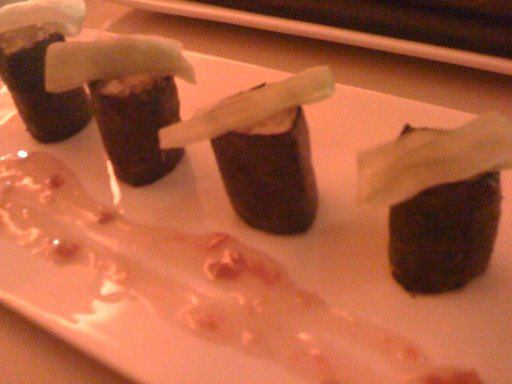

In [13]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(image_class)

img

In [14]:
from torch.utils.data import DataLoader

In [15]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [16]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [17]:
print(f"Train data: \n{train_data}\nTest data: \n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [18]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
os.cpu_count()

2

In [20]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=2,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [21]:
label_splits = {}

In [22]:
list(os.scandir(image_path))

[<DirEntry 'train'>, <DirEntry 'test'>]

In [23]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(

            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2,
                         stride=2)
            
        )

        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),

            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            
            nn.ReLU(),

            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
            

    def forward(self, x: torch.Tensor):

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)

        return x

        

In [24]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

In [25]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from torchinfo import summary

In [27]:
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [28]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)

    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc





In [35]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    model.eval()

    test_loss, test_acc = 0,0

    with torch.inference_mode():

        for batch, (X,y) in enumerate(dataloader): 


            X,y = X.to(device), y.to(device)
            test_pred = model(X)

            loss = loss_fn(test_pred, y)

            test_loss += loss.item()

            test_pred_labels = test_pred.argmax(dim=1)

            test_acc += ((test_pred_labels == y)).sum().item()/len(test_pred_labels)


    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc










In [36]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []
        }

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn, 
                                           optimizer = optimizer)
        
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss} |"
            f"train_acc: {train_acc} |"
            f"test_loss: {test_loss} |"
            f"test_acc: {test_acc}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

    


In [37]:
num_epochs = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)


In [38]:
model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer=optimizer,
                        loss_fn = loss_fn,
                        epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1217219531536102 |train_acc: 0.2734375 |test_loss: 1.1240655183792114 |test_acc: 0.2604166666666667
Epoch: 2 | train_loss: 1.0994695872068405 |train_acc: 0.26171875 |test_loss: 1.0896894931793213 |test_acc: 0.5416666666666666
Epoch: 3 | train_loss: 1.0966105312108994 |train_acc: 0.40234375 |test_loss: 1.0924841562906902 |test_acc: 0.5416666666666666
Epoch: 4 | train_loss: 1.0984995067119598 |train_acc: 0.28125 |test_loss: 1.087746024131775 |test_acc: 0.5416666666666666
Epoch: 5 | train_loss: 1.0943395346403122 |train_acc: 0.31640625 |test_loss: 1.0931038856506348 |test_acc: 0.28882575757575757


In [39]:
import matplotlib.pyplot as plt

In [45]:
def plot_loss_curves(results: dict[str, list[float]]):

    epochs = range(len(results["train_loss"]))

    loss = results["train_loss"]

    test_loss = results["test_loss"]

    accuracy = results["train_acc"]

    test_acc = results["test_acc"]

    plt.figure(figsize=[15,7])

    plt.subplot(1,2,1)

    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    plt.subplot(1,2,2)

    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();











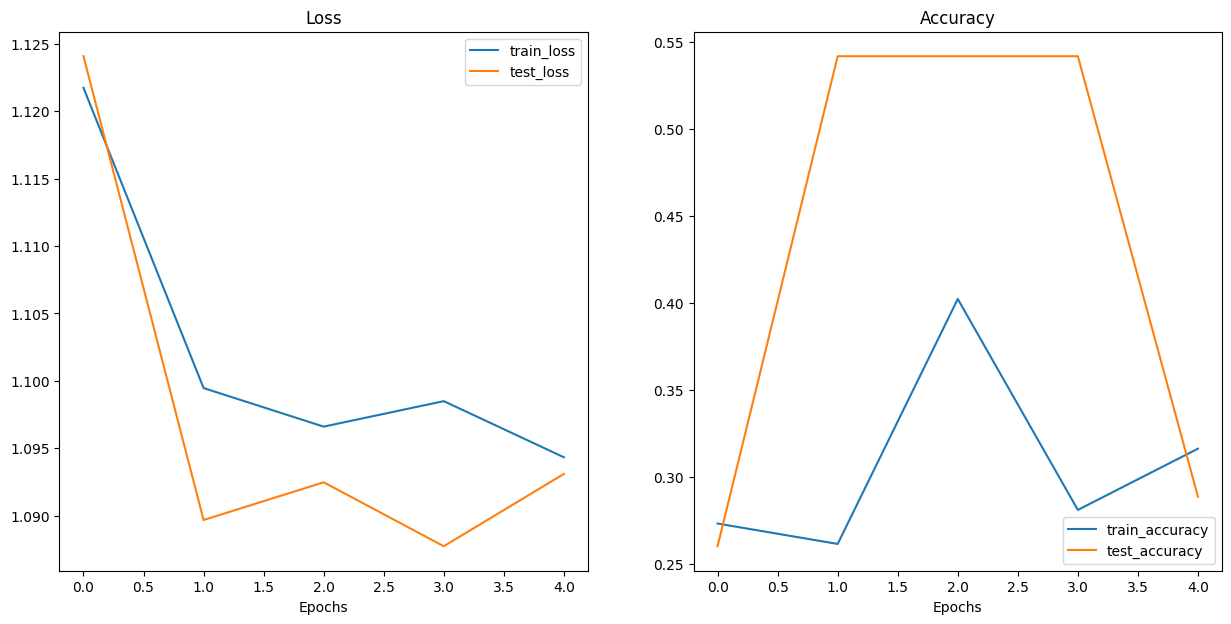

In [46]:
plot_loss_curves(model_0_results)